# Imports

In [1]:
import numpy as np
import pandas as pd
import time
import sys
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import random
import scipy
from scipy.optimize import curve_fit
import scipy.optimize as op
from scipy.integrate import quad 
from scipy.interpolate import interp1d

from pax import units, configuration
pax_config = configuration.load_configuration('XENON1T')['DEFAULT']
tpc_height = pax_config['tpc_length']
tpc_radius = pax_config['tpc_radius']


from multihist import Histdd

import logging
logging.getLogger('hax.minitrees').setLevel(logging.INFO)


# Plotting Parameters

In [2]:
params = {
    'font.family': 'serif',
    'font.size' : 24, 'axes.titlesize' : 42, 'axes.labelsize' : 32, 'axes.linewidth' : 2,
    # ticks
    'xtick.labelsize' : 24, 'ytick.labelsize' : 24, 'xtick.major.size' : 16, 'xtick.minor.size' : 8,
    'ytick.major.size' : 16, 'ytick.minor.size' : 8, 'xtick.major.width' : 2, 'xtick.minor.width' : 2,
    'ytick.major.width' : 2, 'ytick.minor.width' : 2, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 8, 'lines.markeredgewidth' : 2, 'errorbar.capsize' : 5, 'lines.linewidth' : 2,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 24,
    'axes.labelsize': 24, 'axes.titlesize':24, 'xtick.labelsize':18, 'ytick.labelsize':18,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':12,
    # ticks
    'xtick.major.pad': 6,   'xtick.minor.pad': 6,   
    'ytick.major.pad': 3.5, 'ytick.minor.pad': 3.5,
}
plt.rcParams.update(params)

# Conversions

In [3]:
xenon_density = 0.002862 #kg/cm^3 
z = tpc_height # cm
time_ns_to_s = 1/1e9 # s
time_s_to_days = 1/60/60/24 # days
mass_kg_to_tonne = 1/1000 # tonne

drift_velocity = 1 # mm/us
x_mm_to_cm = 1/10 # cm
time_ns_to_us = 1/1000 # us

# Load Data

In [4]:
a1 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180215_1029.h5')
a2 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180215_1035.h5')
a3 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_0923.h5')
a4 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_1124.h5')
a5 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_1324.h5')
a6 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_1455.h5')
a7 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_1625.h5')
a8 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_1755.h5')
a9 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_1926.h5')
a10 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_2056.h5')
a11 = pd.read_hdf('/depot/darkmatter/data/jupyterhub/Amanda/Triggerless_minitrees/Triggerless_0.3.2/180216_2226.h5')

data = a1.append(a2).append(a3).append(a4).append(a5).append(a6).append(a7).append(a8).append(a9).append(a10).append(a11)

In [5]:
#to conserve memory
del a1, a2, a3, a4, a5, a6, a7, a8, a9, a10, a11

In [6]:
#since time can't be negative
data = data[data['gcenter_time_primary'] > 0]
data = data.sort_values('gcenter_time')
data = data.reset_index(drop=True)

## Calculating the amount of time to be considered after a primary
Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb

In [7]:
df_prim = data.drop_duplicates(['gcenter_time_primary'])
df_prim = df_prim.sort_values('gcenter_time')
df_prim = df_prim.reset_index(drop=True)

window = np.zeros(len(data))

p_ind = 1
next_prim_time = df_prim['gcenter_time_primary'].values[p_ind]


for i in tqdm.trange(len(data)):
    window[i] = next_prim_time - data['gcenter_time_primary'].values[i]
    
    if i == len(data) - 1:
            break
    
    elif (i < len(data)) & (data['gcenter_time_primary'].values[i+1] == next_prim_time):
        p_ind += 1
        
        if p_ind <= len(df_prim)-1:
            next_prim_time = df_prim['gcenter_time_primary'].values[p_ind]
        else:
            next_prim_time = data['gcenter_time'].values[-1]

data['livetime_new'] = window

100%|█████████▉| 13116339/13123509 [01:38<00:00, 133582.90it/s]

In [8]:
del df_prim, window

# 1. Livetime Cuts

 - Overlap 
 - S2AreaFractionTop
 - S2PatternLikelihood
 - S2Width
 - DAQ Busy
 - Pretigger
 - S1 cut

## 1.1 Overlap Cut

Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L190

In [9]:
def overlap(df):
        """
        """
        def power(x, a, b):
            return a * x ** -b
        
        gamma = 1
        percent = 0.5 #50% purity 
        max_dt = 1e9
        #bounds for integration
        t_0 = 2e6
        t_1 = 200e6
        R_1 = [0,0]

        primary_time_variable = 'gcenter_time_primary'
        peak_time_variable = 'gcenter_time'
        primary_area_variable = 'area_primary'
        
        df_unique =df.drop_duplicates([primary_time_variable])
        pass_cut=np.zeros(len(df))
        window_length=np.zeros(len(df))
        counter=0
        for index, primary in (df_unique.iterrows()):

            R_0_tot = 0
            win = -1
            next_index = np.nan
            if index == df_unique.index[0]:
                counter+=1
                continue

            else:
                if counter<len(df_unique)-1:
                    next_index=df_unique.index[counter+1]
                    win = df_unique[primary_time_variable].iloc[counter+1] - df_unique[primary_time_variable].iloc[counter]
                    window_length[index:next_index]=win

                else:
                    next_index=len(df)
                    win = df[peak_time_variable].iloc[-1] - df_unique[primary_time_variable].iloc[counter]
                    window_length[index:next_index]=win

                for k in range(counter-1,-1,-1):

                    if np.abs((df_unique[primary_time_variable].iloc[counter]-df_unique[primary_time_variable].iloc[k])) <= max_dt:

                        t_counter = df_unique[primary_time_variable].iloc[counter]
                        t_k = df_unique[primary_time_variable].iloc[k]

                        amp_counter = df_unique[primary_area_variable].iloc[counter]
                        amp_k = df_unique[primary_area_variable].iloc[k]

                        R_1 = quad(power, t_0, t_1, args=(amp_counter,gamma))
                        R_0 = quad(power, (t_counter-t_k)+t_0, (t_counter-t_k)+t_1, args=(amp_k,gamma))
                        R_0_tot += R_0[0]

                    else:
                        break


                if R_0_tot <= 0:
                    R_0_tot = 0

                if R_1[0] == 0:
                    sum_ratio = 0
                else:
                    sum_ratio = R_1[0]/(R_0_tot+R_1[0])

                if sum_ratio >= percent:
                    pass_cut[index:next_index]=1

            counter += 1
        df.loc[:,'ClusterCut_power']=pass_cut
        df.loc[:,'livetime_old']=window_length
        
        df.loc[:, 'CutOverlap'] = (df['ClusterCut_power'] == 1)
        return df

In [10]:
data = overlap(data)

100%|█████████▉| 13116339/13123509 [01:50<00:00, 133582.90it/s]

In [11]:
data = data[(data.CutOverlap)]

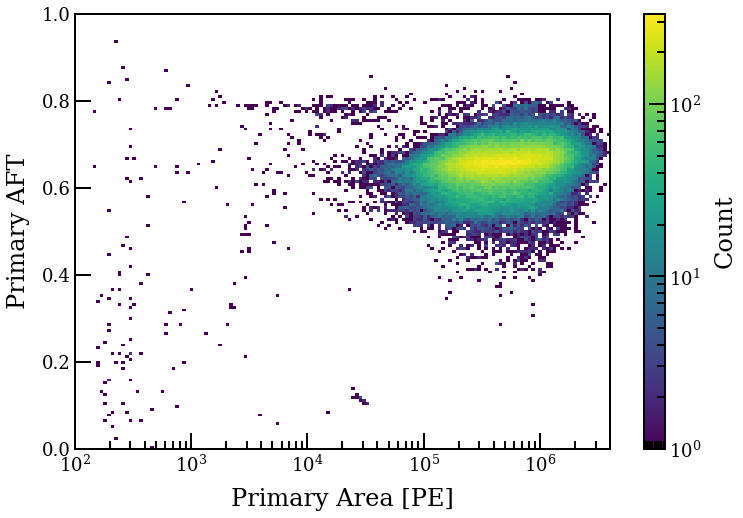

In [12]:
f = plt.figure(figsize=(12,8))

data_prim = data[data['dt_primary'] == 0]

m2 = Histdd(data_prim['area_primary'].values,
            data_prim['area_fraction_top_primary'].values,
            bins=[np.logspace(2,np.log10(4e6),150),np.linspace(0,1,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')

plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('Primary AFT')
plt.show()

## 1.3 Pretigger and Livetime Cut

Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb

https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:single_electron:overview:framework

https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:shengchaoli:single_electron:livetime_cut

In [13]:
data_cut = data[data['livetime_new'] > 1e6] #remove events with livetimes < 1 ms
data_cut = data_cut[(data_cut['livetime_new'].values-data_cut['dt_primary'].values) > 1e6] #remove e- within 1 ms of next prim
data_cut = data_cut[data_cut['livetime_new'].values*time_ns_to_s < 20] #max livetime is 20s

data_cut['event_window_seconds'] = (data_cut['livetime_new'].values - 1e6)*time_ns_to_s #reduce livetime by 1 ms
data_cut['delay_time_seconds'] = (data_cut['dt_primary'].values)*time_ns_to_s #convert delay time to seconds

In [14]:
del(data)

In [26]:
def DAQBusy(df):
        
        """veto columns with gcenter_time_primary in the busy_list
        """
        def drop_runs_unincluded(df,df_b):
            file_list= np.array(df_b['run_number'].drop_duplicates())
            df_no_match = df[~df['run_number'].isin(file_list)]
            if(len(df_no_match)>0):
                print("WARNING:", np.array(df_no_match['run_number'].drop_duplicates()), 'is not in the processed busy list!')
            else:
                print('All data matched in the busy list.')
        
        import pandas as pd
        busy_df = pd.read_csv('/depot/darkmatter/data/jupyterhub/Shengchao/data/triggerless_busy_prim.3.2.h5')
        busy_df2 = pd.read_csv('/depot/darkmatter/data/jupyterhub/Shengchao/data/triggerless_busy_prim.3.2_batch3.csv')
        busy_df = busy_df.append(busy_df2)
        drop_runs_unincluded(df,busy_df)
        busy_list =  busy_df['gcenter_time_primary'].unique()
        print('total %i busy primary events in list.'%len(busy_list))
        df['DAQ_busy'] = df['gcenter_time_primary'].isin(busy_list.tolist())
        
        df.loc[:, 'CutDAQBusy'] = (df['DAQ_busy'] == 0)

        return df

In [27]:
data_cut = DAQBusy(data_cut)
data_cut = data_cut[data_cut['CutDAQBusy']]

All data matched in the busy list.
total 82737 busy primary events in list.


### Remove peaks after S1 

In [29]:
data_s1 = data_cut[(data_cut['type_digit'] == 1) & (data_cut['dt_primary'].values > 2e6) ]

dt_s1 = np.zeros(len(data_cut))
time_s1 = np.zeros(len(data_cut))
dt_s1_prim = np.zeros(len(data_cut))


time_prim = data_cut['gcenter_time_primary'].values[0]
for i in tqdm.trange(len(data_cut)):
 
    difference = data_cut['gcenter_time'].values[i] - data_s1['gcenter_time'].values
    if len(difference[difference > 0]) == 0:
        pass 
    else:
        #arg gets the S1 closest to this peak
        arg = np.argmin(difference[difference > 0])
        dt_s1[i] = difference[arg]
        time_s1[i] = data_s1['gcenter_time'].values[arg]
        dt_s1_prim[i] = data_s1['gcenter_time'].values[arg] - data_s1['gcenter_time_primary'].values[arg]


data_cut['nearest_s1_dt'] = dt_s1
data_cut['gcenter_time_s1'] = time_s1
data_cut['s1_dt_primary'] = dt_s1_prim



100%|██████████| 8482409/8482409 [15:32<00:00, 9099.96it/s]

In [30]:
data_s1 = data_cut[(data_cut['type_digit'] == 1) & (data_cut['dt_primary'].values > 2e6) ]
number_of_s1 = data_s1.groupby(['gcenter_time_primary']).apply(lambda x: x.sort_values(['gcenter_time']))

data_cut = data_cut[data_cut['nearest_s1_dt']/1e9 >= 2e-3]

In [33]:
len(data_cut)

8332787

## Cuts for selecting primaries in liquid
https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:single_electron:primary_selection


In [34]:
# AFT cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L31
def lower_limit_s2_aft(s2):
    return 0.6648160611018054 - 2.590402853814859e-07 * np.clip(s2, 0, 50000) - 0.8531029789184852 / np.log(np.clip(s2, 0, 50000))

def upper_limit_s2_aft_l(s2):
    extended_upper_bound = np.load('ExtendedUpperBand.npz')
    upper_band_interp =  interp1d(extended_upper_bound['x_bins'], 
                              extended_upper_bound['combined_upper'], 
                              bounds_error=False, fill_value = (extended_upper_bound['combined_upper'][0],
                                                              extended_upper_bound['combined_upper'][-1]),
                                kind="linear")
    return upper_band_interp(s2)

data_liquid = data_cut[data_cut['area_fraction_top_primary'] < upper_limit_s2_aft_l(data_cut['area_primary'])]
data_liquid = data_liquid[data_liquid['area_fraction_top_primary'] > lower_limit_s2_aft(data_liquid['area_primary'])]


In [35]:
# Pattern cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L31
def goodness_of_fit_s2(s2):
    return (0.0390 * s2 + 609 * s2**0.0602 - 666)

data_liquid = data_liquid[data_liquid['goodness_of_fit_primary'] < goodness_of_fit_s2(data_liquid['area_primary'])]


In [36]:
# Width cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L105

data_liquid = data_liquid[(data_liquid['wr_avg_primary'] > 120) & (data_liquid['wr_avg_primary'] < 2500)]


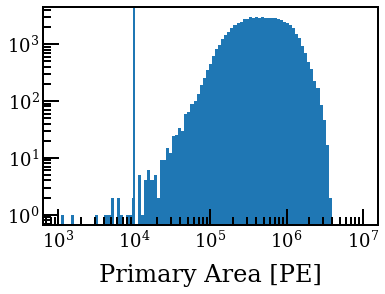

In [37]:
# Threshold cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L160

data_prim = data_liquid[data_liquid['dt_primary'] == 0]
plt.hist(data_prim['area_primary'],bins=np.logspace(3,7,100))
plt.xscale('log')
plt.yscale('log')
plt.axvline(1e4)
plt.xlabel('Primary Area [PE]')
plt.show()
data_liquid = data_liquid[data_liquid['area_primary'] > 10000]

## Cuts for selecting primaries in gas

In [38]:
# AFT cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L31
def upper_limit_s2_aft_g(s2):
    return 0.7 + 1e-06 * np.clip(s2, 0, 200000) + 0.3/ np.log(np.clip(s2, 0, 50000))
data_gas = data_cut[data_cut['area_fraction_top_primary'] > upper_limit_s2_aft_g(data_cut['area_primary'])]

In [39]:
# Width cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L105

data_gas = data_gas[(data_gas['wr_avg_primary'] > 120) & (data_gas['wr_avg_primary'] < 2500)]

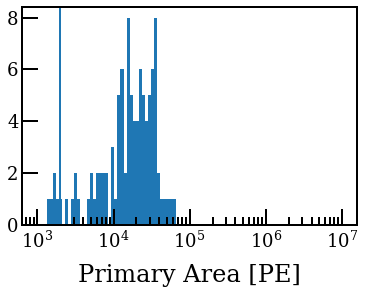

In [40]:
# Threshold cut - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L160

data_prim = data_gas[data_gas['dt_primary'] == 0]
plt.hist(data_prim['area_primary'],bins=np.logspace(3,7,100))
plt.xscale('log')
plt.axvline(2e3)
plt.xlabel('Primary Area [PE]')
plt.show()
data_gas = data_gas[data_gas['area_primary'] > 2000]

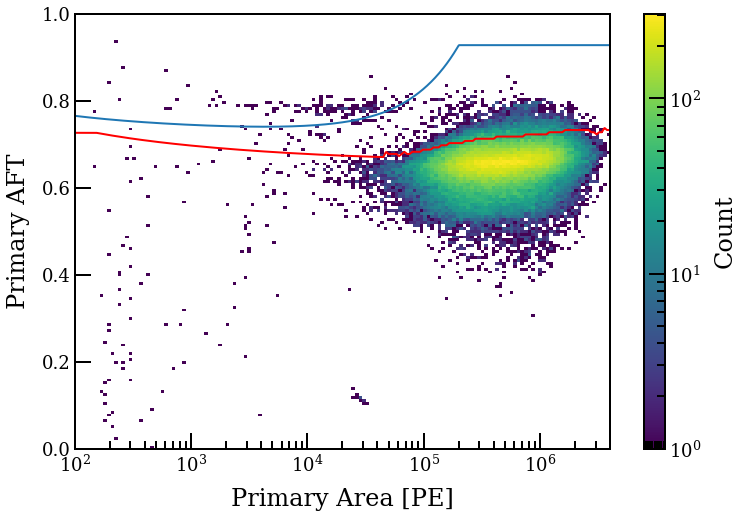

In [41]:
f = plt.figure(figsize=(12,8))

x = np.logspace(2,7,1000)
y1 = upper_limit_s2_aft_l(x)
plt.plot(x,y1,'r')

y1 = upper_limit_s2_aft_g(x)
plt.plot(x,y1)

data_prim = data_cut[data_cut['dt_primary'] == 0]

m2 = Histdd(data_prim['area_primary'].values,
            data_prim['area_fraction_top_primary'].values,
            bins=[np.logspace(2,np.log10(4e6),150),np.linspace(0,1,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')

plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('Primary AFT')
plt.show()

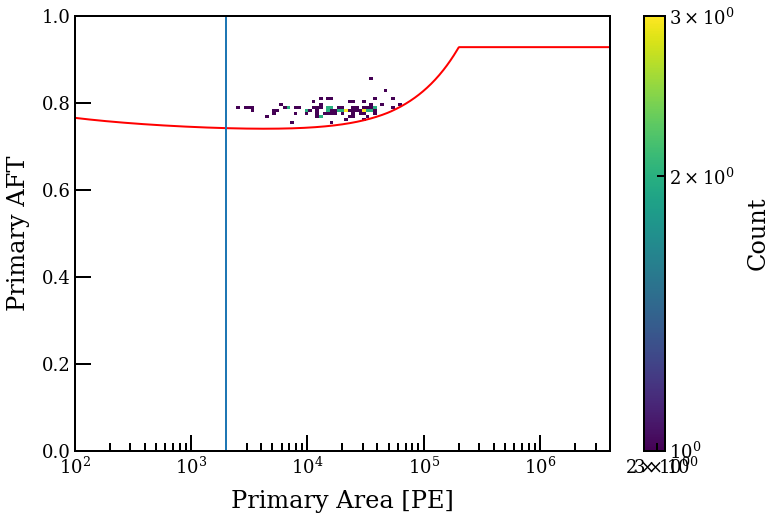

In [42]:
f = plt.figure(figsize=(12,8))

data_prim = data_gas[data_gas['dt_primary'] == 0]

m2 = Histdd(data_prim['area_primary'].values,
            data_prim['area_fraction_top_primary'].values,
            bins=[np.logspace(2,np.log10(4e6),150),np.linspace(0,1,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
plt.plot(x,y1,'r')
plt.axvline(2e3)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('Primary AFT')
plt.show()

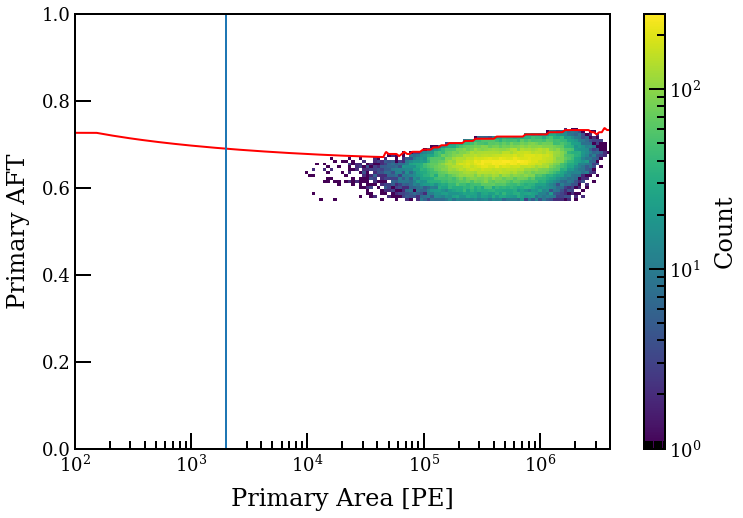

In [44]:
f = plt.figure(figsize=(12,8))

data_prim = data_liquid[data_liquid['dt_primary'] == 0]

m2 = Histdd(data_prim['area_primary'].values,
            data_prim['area_fraction_top_primary'].values,
            bins=[np.logspace(2,np.log10(4e6),150),np.linspace(0,1,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
y1 = upper_limit_s2_aft_l(x)
plt.plot(x,y1,'r')
plt.axvline(2e3)
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('Primary AFT')
plt.show()

# 2. Adding various paramters needed for other cuts
- dr 
- dwtiddle
- area correaction
- wr_diff
- drift time

Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb 

In [46]:
def get_parameters(data_cut):
    xdiff = data_cut['x_primary'].values - data_cut['x'].values
    ydiff = data_cut['y_primary'].values - data_cut['y'].values


    data_cut['x_diff'] = xdiff
    data_cut['y_diff'] = ydiff
    data_cut['r_diff'] = np.nan_to_num(np.sqrt(xdiff**2 + ydiff**2))
    circle_r = 50
    circle_x = 0
    circle_y = 0
    x = []
    y = []
    for i in range(1000):
        alpha = 2 * math.pi * random.random()
        r = circle_r * math.sqrt(random.random())
        x.append(r * math.cos(alpha) + circle_x)
        y.append(r * math.sin(alpha) + circle_y)


    d_prim = data_cut.drop_duplicates(['gcenter_time_primary'])
    x_prim = d_prim['x_primary'].values
    y_prim = d_prim['y_primary'].values
    len_y = len(y)
    len_prim = len(d_prim)

    import numba
    @numba.njit 
    def dis(x,y):
        d2 = []
        for i in range(len_prim):
            for j in range(len_y):
                d2.append((x_prim[i] - x[j])**2 + (y_prim[i]-y[j])**2)
        return d2
    d2 = dis(x,y)
    d = np.sqrt(d2)

    d_hist, d_bins = np.histogram(np.nan_to_num(d), bins=np.linspace(0,100,10000))
    corrdinate_transofmration_histogram = np.cumsum(d_hist)/max(np.cumsum(d_hist))
    d_twiddle = []
    for r_old in data_cut['r_diff']:
        location = np.argmin(abs(d_bins[1:]-r_old))
        d_twiddle.append(corrdinate_transofmration_histogram[location])

    data_cut['d_twiddle'] = d_twiddle

    def area_calulation_inner(df_i, dr_cut, fv_cut):

        d = np.sqrt(df_i['x_primary']**2 + df_i['y_primary']**2)

        if dr_cut == 0:
            area_frac_inner = 0

        elif dr_cut + d < fv_cut:
            area_frac_inner = np.pi*dr_cut**2

        elif d > fv_cut + dr_cut:
            area_frac_inner = 0

        elif d + fv_cut < dr_cut:
            area_frac_inner = np.pi*fv_cut**2

        else:
            area_frac_inner = dr_cut**2*np.arccos((d**2+dr_cut**2-fv_cut**2)/(2*d*dr_cut)) \
                       + fv_cut**2*np.arccos((d**2+fv_cut**2-dr_cut**2)/(2*d*fv_cut)) \
                       -0.5*np.sqrt((-d+dr_cut+fv_cut)*(d+dr_cut-fv_cut)*(d-dr_cut+fv_cut)\
                                    *(d+dr_cut+fv_cut))

        return area_frac_inner

    def area_calulation_outer(df_i, dr_cut, fv_cut):

        d = np.sqrt(df_i['x_primary']**2 + df_i['y_primary']**2)

        if dr_cut == 0:
            area_frac_outer = np.pi*fv_cut**2

        elif dr_cut + d < fv_cut:
            area_frac_outer = np.pi*fv_cut**2 - np.pi*dr_cut**2

        elif d > fv_cut + dr_cut:
            area_frac_outer = np.pi*fv_cut**2

        elif d + fv_cut < dr_cut:
            area_frac_outer = 0

        else:
            area_overlap = dr_cut**2*np.arccos((d**2+dr_cut**2-fv_cut**2)/(2*d*dr_cut)) \
                       + fv_cut**2*np.arccos((d**2+fv_cut**2-dr_cut**2)/(2*d*fv_cut)) \
                       -0.5*np.sqrt((-d+dr_cut+fv_cut)*(d+dr_cut-fv_cut)*(d-dr_cut+fv_cut)\
                                    *(d+dr_cut+fv_cut))

            area_frac_outer = np.pi*fv_cut**2 - area_overlap

        return area_frac_outer

    dr_cut_inner = 15
    dr_cut_outer = 20
    fv_cut = tpc_radius

    area_inner = []
    area_outer = []

    for i in tqdm.trange(len(data_cut)):
        area_inner_i = area_calulation_inner(data_cut.iloc[i], dr_cut_inner, fv_cut)
        area_outer_i = area_calulation_outer(data_cut.iloc[i], dr_cut_outer, fv_cut)

        area_inner.append(area_inner_i)
        area_outer.append(area_outer_i)

    data_cut['area_inner'] = area_inner
    data_cut['area_outer'] = area_outer


    data_cut = data_cut[data_cut['area_inner'] > 0]
    data_cut = data_cut[data_cut['area_outer'] > 0]

    data_cut['wr_diff'] = (data_cut['range_50p_area'] - data_cut['rise_time'] * 0.5) / 2
    return data_cut

In [47]:
data_gas = get_parameters(data_gas)


/apps/cent7/jupyterhub/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'get_parameters.<locals>.dis'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_89965/3613420579.py", line 28:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/apps/cent7/jupyterhub/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'y' of function 'get_parameters.<locals>.dis'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "

In [48]:
data_liquid = get_parameters(data_liquid)

/apps/cent7/jupyterhub/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'x' of function 'get_parameters.<locals>.dis'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../tmp/ipykernel_89965/3613420579.py", line 28:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/apps/cent7/jupyterhub/lib/python3.9/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'y' of function 'get_parameters.<locals>.dis'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "

In [61]:
def primaries(data_cut):
    data_prim = data_cut.drop_duplicates(['gcenter_time_primary'])

    num_s1_all = []
    livetime_all = []
    for i in tqdm.trange(len(data_prim)):
        num_s1 = len(number_of_s1[(number_of_s1['gcenter_time_primary'].values == data_prim['gcenter_time_primary'].values[i])])
        num_s1_all.append(num_s1)  

        livetime_final = (data_prim['event_window_seconds'].values[i] - 2e-3*num_s1)
        livetime_all.append(livetime_final)

    data_prim['final_livetime_seconds'] = livetime_all
    return data_prim

In [62]:
data_prim_liquid = primaries(data_liquid)
data_prim_gas = primaries(data_gas)


100%|██████████| 74460/74460 [00:11<00:00, 6264.79it/s]/tmp/ipykernel_89965/1375707722.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_prim['final_livetime_seconds'] = livetime_all

100%|██████████| 760/760 [00:00<00:00, 6310.28it/s]

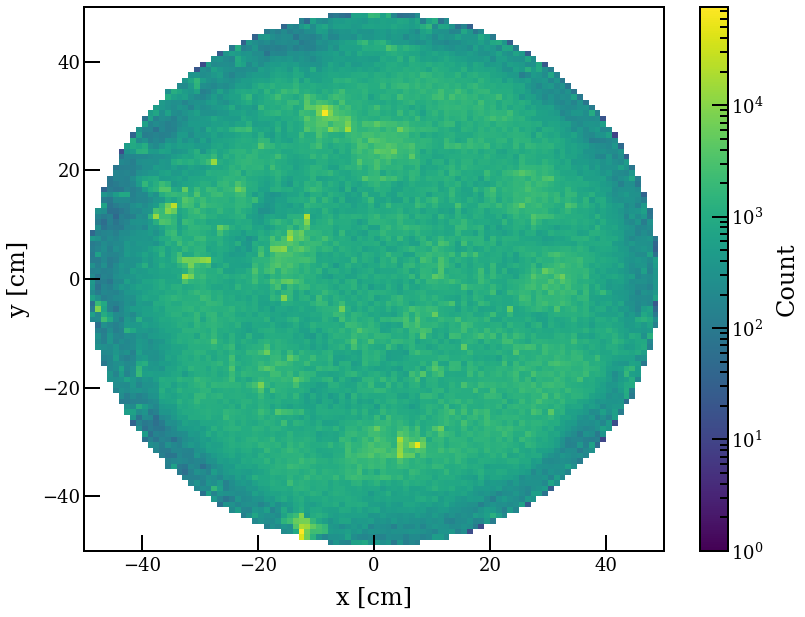

In [55]:
f = plt.figure(figsize=(13,10))
m2 = Histdd(data_cut['x'].values, data_cut['y'].values, 
            bins=[np.linspace(-50,50,101),np.linspace(-50,50,101)], norm=LogNorm())

m2.plot(cblabel = 'Count', log_scale = True)

plt.xticks()
plt.yticks()
plt.xlabel('x [cm]')
plt.ylabel('y [cm]')
# plt.legend()
# plt.title('1 electron', fontsize=20)
plt.show()

## SE AFT cut
Taken from https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/lichens.py#L138

In [52]:
def get_electrons(data_cut):
    data_lowE = data_cut[(data_cut['area'] > 10) &
                         (data_cut['area'] < 150) &
                         (data_cut['type_digit'] == 2)]
    def upper_limit_se_aft(se):
            return  0.7979618790092939 - 0.0009151836797055721 * se + 0.31048577140830913/ np.log(se)

    def lower_limit_se_aft(se):
            return 0.7911258726137005 + 1.0683840700509688e-05 * se - 1.6683755178966946 / np.log(se)

    data_lowE = data_lowE[((data_lowE['area_fraction_top'] < upper_limit_se_aft(data_lowE['area'])) &
                              (data_lowE['area_fraction_top'] > lower_limit_se_aft(data_lowE['area'])))
                       ]

    print (len(data_lowE))

    f = plt.figure(figsize=(12,8))

    m2 = Histdd(data_lowE['area'].values,
                data_lowE['area_fraction_top'].values,
                bins=[np.linspace(0,150,151),np.linspace(0,1,150)])


    m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')

    # plt.xscale('log')
    # plt.yscale('log')
    plt.xlabel('Area [PE]')
    plt.ylabel('AFT')
    plt.show()
    
    return data_lowE

4100182


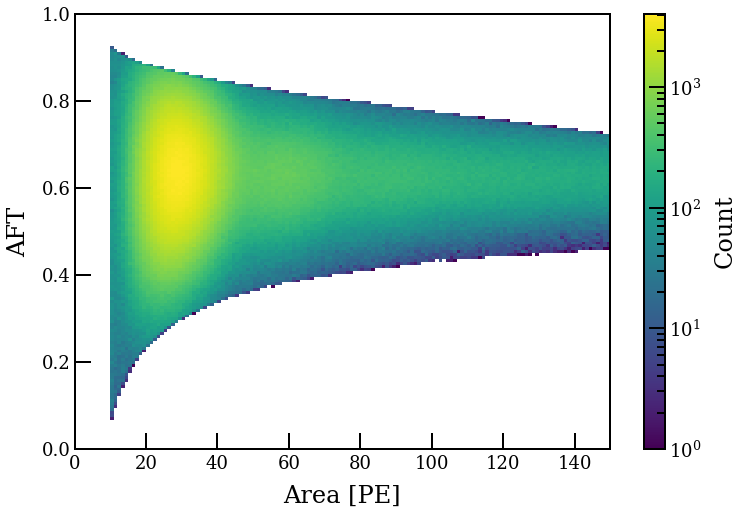

In [53]:
data_se_liquid = get_electrons(data_liquid)

1922


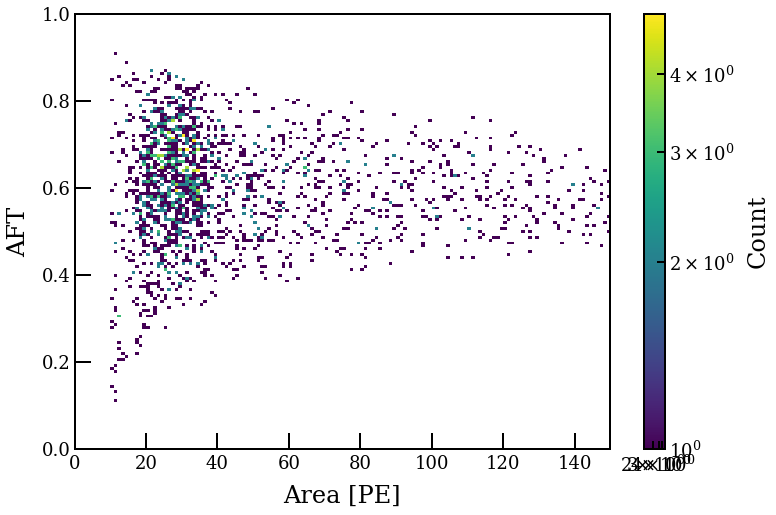

In [54]:
data_se_gas = get_electrons(data_gas)

# Plot Power Law and Get Fraction

In [63]:
hist_bins_start = -4
hist_bins_stop = 0.5
hist_num_bins = 25

hist_bins = np.logspace(hist_bins_start,hist_bins_stop,hist_num_bins+1)

In [64]:
def power(x, a, b):
    return a * x ** b

In [65]:
def MLEpower(bins,counts,windows,guesses, eff, pur):
    #Get the corresponding x values, and the bin and window correction
    x = []
    c = []
    r = []
    for i in range(len(bins) - 1):
        x.append((bins[i+1] + bins[i])/2)
        c.append((bins[i+1] - bins[i])*eff*windows[i]/pur)
    #Do the MLE
    def MLE(p):
        L = 0
        for i in range(len(x)):
            f_i = p[0]*((x[i])**p[1])
            L += ( c[i]*f_i - counts[i]*np.log(c[i]*f_i) )
        return L

    results = op.minimize(MLE, guesses, method = 'Nelder-Mead', options={'disp': True, 'maxiter': 1e3})
    A_MLE = results['x'][0]
    b_MLE = results['x'][1]

    #Find the error
    In_A = 0
    In_b = 0

    for i in range(len(x)):
        In_A += counts[i]/(A_MLE**2) 
        In_b += c[i]*A_MLE*(x[i]**b_MLE)*(np.log(x[i])**2)


    errA = np.sqrt(len(x)/In_A)
    errb = np.sqrt(len(x)/In_b)

    
    return A_MLE,b_MLE,errA,errb

In [93]:
def get_frac(df, df_prim, phase, normalized, se_range='w', position_range='w', fit_lower=2*1e-3, fit_upper=200*1e-3, s2_lower=150, s2_upper=1e7, drift_lower=0, drift_upper=1000, correction ='xy'):
    purity_inner = 0.9882
    efficiency_outer = 0.9246
    efficiency_inner = 0.9390
    # Instead of recalculating these values, I am simply using values from here 
    #for liquid - https://github.com/XENON1T/single_electron_analysis/blob/master/triggerless/000_GetRates_everything.ipynb
    #and for gas - darkmatter/Amanda/SE_notebooks/00_AD_Standard_Plots_notliquid_Gas.ipynb
    if phase == 'liquid':
        n = 2
        mean1 = 28.88
        sig1 = 7.18
        purity_se = 0.9938
        efficiency_se = 0.9561
        
    if phase == 'gas':
        n = 2
        mean1 = 28.03
        sig1 = 7.18
        purity_se = 0.9962
        efficiency_se = 0.9422
          
    SEmin = mean1 - n*sig1
    SEmax = mean1 + n*sig1    
    if se_range == 'se':
        df_here = df[(df['area'] > SEmin) & (df['area'] <= SEmax)]
        pur_e = purity_se
        eff_e = efficiency_se
    if se_range == 'de':
        df_here = df[(df['area'] > DEmin) & (df['area'] <= DEmax)]
        pur_e = purity_de
        eff_e = efficiency_de
    if se_range == 'fe':
        df_here = df[(df['area'] > FEmin) & (df['area'] <= FEmax)]
        pur_e = purity_fe
        eff_e = efficiency_fe
    
    if correction == 'xy':
        primary_area = df_here['carea_primary']
        primary_area_prim = df_prim['carea_primary']
    if correction == 'xyz':
        primary_area = df_here['cS2']
        primary_area_prim = df_prim['cS2']
    
    
    df_here = df_here[(primary_area > s2_lower)
                    & (primary_area <= s2_upper)
#                     & (df_here['drift_time_us'] > drift_lower)
#                     & (df_here['drift_time_us'] <= drift_upper)
                    ]
    
    df_prim_here = df_prim[(primary_area_prim > s2_lower)
                    & (primary_area_prim <= s2_upper)
#                     & (df_prim['drift_time_us'] > drift_lower)
#                     & (df_prim['drift_time_us'] <= drift_upper)
                    ]

    
    if position_range == 'all':
        area_correction = np.ones(len(df_here))
        ylabel = 'Rate [$ e^{-1}. s^{-1} $]'
        pur_pos = 1
        eff_pos = 1
    if position_range == 'inner':
        df_here = df_here[df_here['r_diff'] < 15]
        area_correction = df_here['area_inner']
        ylabel = 'Rate [$ e^{-1}. s^{-1}. cm^{-2} $]'
        pur_pos = purity_inner
        eff_pos = efficiency_inner
    if position_range == 'outer':
        df_here = df_here[df_here['r_diff'] > 20]
        area_correction = df_here['area_outer']
        ylabel = 'Rate [$ e^{-1}. s^{-1}. cm^{-2} $]'
        pur_pos = purity_inner
        eff_pos = efficiency_outer
        
    purity = pur_e*pur_pos
    efficiency = eff_e*eff_pos
        
    if correction == 'xy':
        primary_area = df_here['carea_primary']
        primary_area_prim = df_prim['carea_primary']
    if correction == 'xyz':
        primary_area = df_here['cS2']
        primary_area_prim = df_prim['cS2']
        
    se = mean1

    # Counts histogram 
    f_counts = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins)
    bin_heights = f_counts[0]
    bin_width = f_counts[1][1:] - f_counts[1][:-1]
    bin_centers = f_counts[1][:-1] + 0.5*bin_width
    if normalized:
        f_counts_corrected = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,
                                    weights = np.ones(len(df_here))/area_correction/primary_area)
        f_counts_corrected_error_hist,_ = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,
                                        weights = (np.ones(len(df_here))/area_correction/primary_area)**2)
    else:
        f_counts_corrected = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,
                                    weights = np.ones(len(df_here))/area_correction)
        f_counts_corrected_error_hist,_ = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,
                                        weights = (np.ones(len(df_here))/area_correction)**2)
    f_counts_corrected_errorbar = np.sqrt(f_counts_corrected_error_hist)
    plt.errorbar(bin_centers ,f_counts_corrected[0], f_counts_corrected_errorbar ,
                 ecolor ='r' ,fmt='none' ,drawstyle = 'steps-mid')

    
    ### rate hist without area correaction
    f_counts_corrected_noarea = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,
                                    weights = np.ones(len(df_here))/(primary_area/se))
    f_counts_corrected_noarea_error_hist,_ = np.histogram(df_here['dt_primary']/1e9, bins=hist_bins,
                                        weights = (np.ones(len(df_here))/(primary_area/se))**2)
    f_counts_corrected_noarea_errorbar = np.sqrt(f_counts_corrected_noarea_error_hist)

    plt.errorbar(bin_centers,f_counts_corrected[0], yerr=f_counts_corrected_errorbar[0],color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid', label='1e')

    plt.legend(fontsize=14)
    plt.title('Raw counts', fontsize=20)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Delay from primary S2 (s)', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
    ### Livetime Plot
    df_unique = df_prim_here
    window_bin_widths = hist_bins[1:]-hist_bins[:-1]
    df_unique['WindowBin'] = np.digitize(df_unique.final_livetime_seconds, bins=hist_bins)
    df_unique = df_unique.mask(df_unique.WindowBin>hist_num_bins-1, hist_num_bins-1)

    f_livetime_full = plt.hist(hist_bins[df_unique.WindowBin-1], bins=hist_bins,  cumulative=-1)
    f_livetime_full_err = np.sqrt(f_livetime_full[0])
    plt.errorbar(bin_centers ,f_livetime_full[0], f_livetime_full_err ,ecolor ='r' ,fmt='none' ,drawstyle = 'steps-mid')
    plt.legend(fontsize=14)
    plt.yscale('log')
    plt.ylabel('Counts', fontsize=20)
    plt.xscale('log')
    plt.xlabel('CDF Livetime (s)', fontsize=20)
    #plt.xlim(1e-3,1e0)
    plt.title('CDF up to last bin', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    f_livetime_part = np.histogram(df_unique.final_livetime_seconds, 
                                   weights=(df_unique.final_livetime_seconds-hist_bins[df_unique.WindowBin-1])/window_bin_widths[df_unique.WindowBin-1], 
                                   bins=hist_bins)
    f_livetime_part_err = np.sqrt(f_livetime_part[0])
    plt.errorbar(bin_centers ,f_livetime_part[0], f_livetime_part_err ,ecolor ='r' , fmt='none' , drawstyle = 'steps-mid')
    plt.legend(fontsize=14)
    plt.yscale('log')
    plt.ylabel('Counts', fontsize=20)
    plt.xscale('log')
    plt.xlabel('CDF Livetime (s)', fontsize=20)
    #plt.xlim(1e-4,1e0)
    plt.title('Fractional livetime of last bin', fontsize=20)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()
    
    # Calculate rate
    
    count = f_counts_corrected[0]/bin_width
    livetime = f_livetime_full[0]+f_livetime_part[0]
    window_err = np.sqrt(livetime)
    rate = (count/livetime)*(purity/efficiency)
    rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
    
    weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])

    count_noarea = f_counts_corrected_noarea[0]/bin_width
    rate_noarea = (count_noarea/livetime)*(purity/efficiency)
    rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
    weight_noarea_factor = np.nan_to_num(f_counts_corrected_noarea[0]/f_counts[0])

    # mask for the fit range
    mask = ((bin_centers > fit_lower) & (bin_centers <= fit_upper))
    centers_fit = bin_centers[mask]
    rate_fit = rate[mask]
    error_fit = rate_err[mask]
    width_fit = bin_width[mask]
    count_fit = f_counts[0][mask]
    livetime_fit = livetime[mask]/weight_factor[mask]
    
    count_fit_noarea = f_counts[0][mask]
    rate_fit_noarea = rate_noarea[mask]
    error_fit_noarea = rate_noarea_err[mask]
    livetime_fit_noarea = livetime[mask]/weight_noarea_factor[mask]


    guess = [1e-10,-1.2]
    results = MLEpower(centers_fit, count_fit, livetime_fit, guess, efficiency, purity)

    guess = [1e-4,-1.1]
    results_noarea = MLEpower(centers_fit, count_fit_noarea, livetime_fit_noarea, guess, efficiency, purity)
    amp = results_noarea[0]
    gam = results_noarea[1]
    power_law = lambda x: amp*x**gam
    integral = scipy.integrate.quad(power_law, fit_lower, fit_upper)[0]*100

    counts = count_fit_noarea
    frac = np.sum(np.nan_to_num(rate_fit_noarea)*width_fit)*100
    frac_err = np.sum(np.nan_to_num(error_fit_noarea)*width_fit)*100


    plt.close()
    
    return rate, rate_err, bin_centers, centers_fit, results, integral, frac, frac_err
  

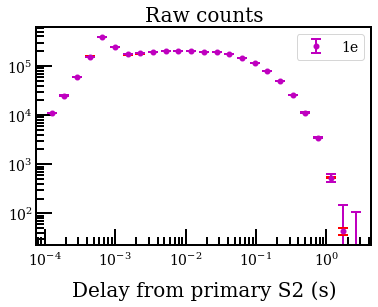

No handles with labels found to put in legend.


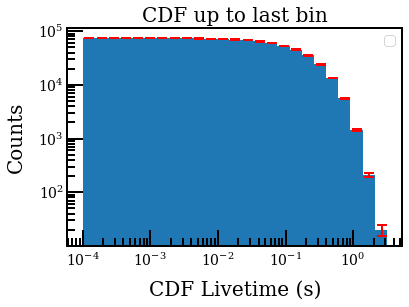

No handles with labels found to put in legend.


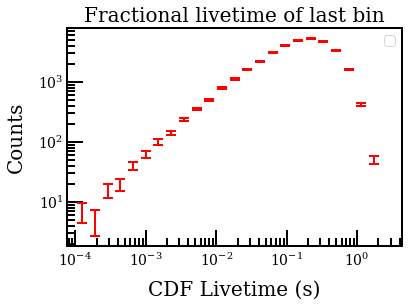

Optimization terminated successfully.
         Current function value: -19970754.302946
         Iterations: 227
         Function evaluations: 428
Optimization terminated successfully.
         Current function value: -19971559.596228
         Iterations: 56
         Function evaluations: 104


/tmp/ipykernel_89965/1170343998.py:164: RuntimeWarning: invalid value encountered in true_divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_89965/1170343998.py:166: RuntimeWarning: invalid value encountered in true_divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])
/tmp/ipykernel_89965/1170343998.py:170: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
/tmp/ipykernel_89965/1170343998.py:171: RuntimeWarning: invalid value encountered in true_divide
  weight_noarea_factor = np.nan_to_num(f_counts_corrected_noarea[0]/f_counts[0])


In [76]:
rate_l_un, rate_err_l_un, bin_centers, centers_fit, results_l_un, integral, frac, frac_err = get_frac(data_se_liquid, data_prim_liquid, 'liquid', False, se_range='se', position_range='all')

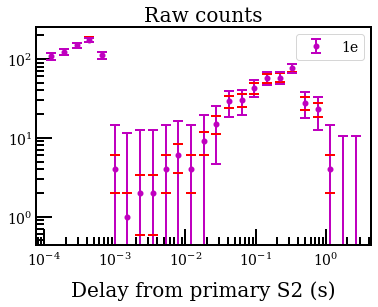

No handles with labels found to put in legend.


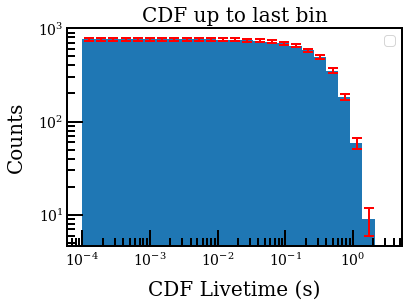

No handles with labels found to put in legend.


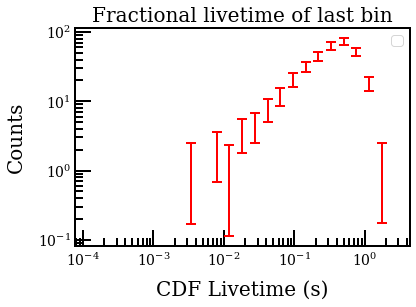

Optimization terminated successfully.
         Current function value: -300.150120
         Iterations: 169
         Function evaluations: 310
Optimization terminated successfully.
         Current function value: -289.895273
         Iterations: 49
         Function evaluations: 93


/tmp/ipykernel_89965/2931770225.py:166: RuntimeWarning: invalid value encountered in true_divide
  rate = (count/livetime)*(purity/efficiency)
/tmp/ipykernel_89965/2931770225.py:167: RuntimeWarning: invalid value encountered in true_divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_89965/2931770225.py:169: RuntimeWarning: invalid value encountered in true_divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])
/tmp/ipykernel_89965/2931770225.py:172: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea = (count_noarea/livetime)*(purity/efficiency)
/tmp/ipykernel_89965/2931770225.py:173: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
/tmp/ipykernel_89965/2931770225.py:174: RuntimeWarning: invalid value encountered in true_divide
  weigh

In [79]:
rate_g_un, rate_err_g_un, bin_centers, centers_fit, results_g_un, integral, frac, frac_err = get_frac(data_se_gas, data_prim_gas, 'gas', False,se_range='se', position_range='all')


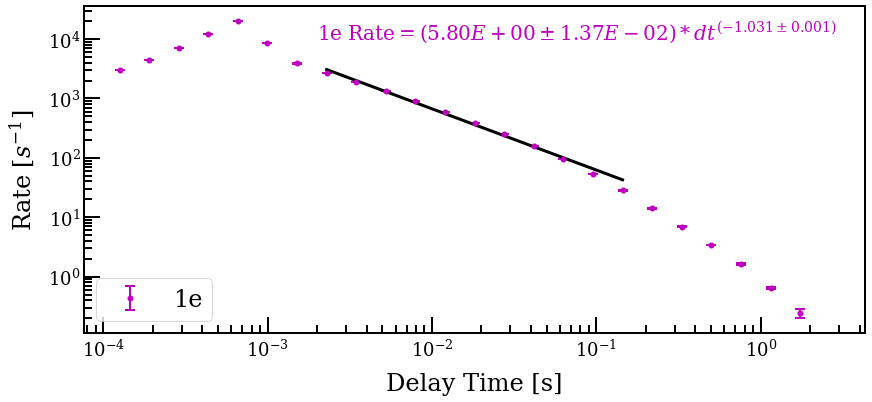

In [80]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_l_un, yerr=rate_err_l_un,color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('1e Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l_un[0], results_l_un[2], results_l_un[1], results_l_un[3]))
curvey1 = power(centers_fit,results_l_un[0],results_l_un[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 1e4), fontsize=20, color='m')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$s^{-1} $]')
# plt.ylim(1e-6,1e1)
plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()

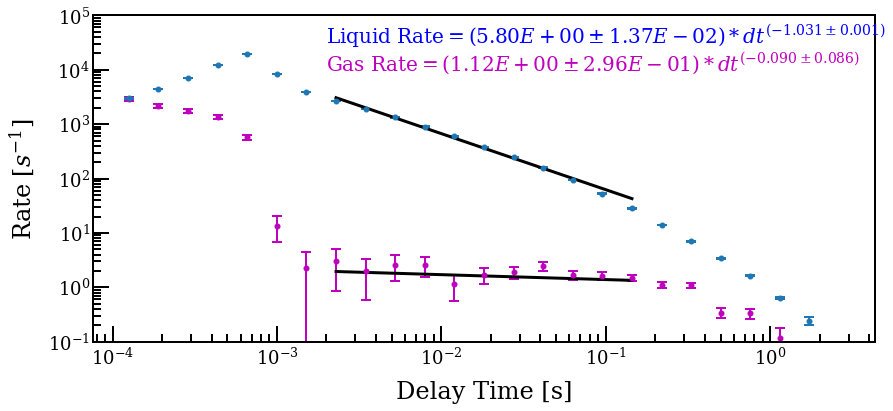

In [83]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_g_un, yerr=rate_err_g_un,color='m', ecolor ='m' , fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g_un[0], results_g_un[2], results_g_un[1], results_g_un[3]))
curvey1 = power(centers_fit,results_g_un[0],results_g_un[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 1e4), fontsize=20, color='m')

plt.errorbar(bin_centers,rate_l_un, yerr=rate_err_l_un,fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l_un[0], results_l_un[2], results_l_un[1], results_l_un[3]))
curvey1 = power(centers_fit,results_l_un[0],results_l_un[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 3e4), fontsize=20, color='b')


plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$s^{-1} $]')
plt.ylim(1e-1,1e5)
plt.xticks()
plt.yticks()
plt.show()

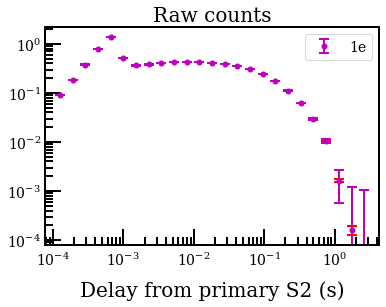

No handles with labels found to put in legend.


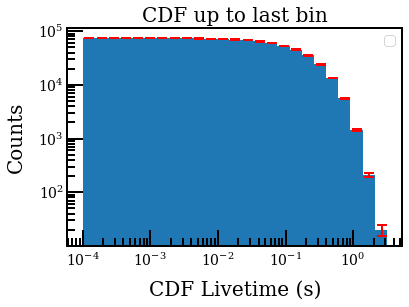

No handles with labels found to put in legend.


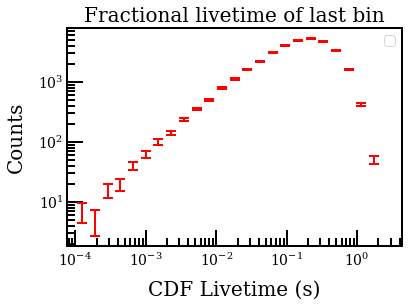

Optimization terminated successfully.
         Current function value: -19971559.596225
         Iterations: 132
         Function evaluations: 241
Optimization terminated successfully.
         Current function value: -19971559.596228
         Iterations: 56
         Function evaluations: 104


/tmp/ipykernel_89965/2931770225.py:167: RuntimeWarning: invalid value encountered in true_divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_89965/2931770225.py:169: RuntimeWarning: invalid value encountered in true_divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])
/tmp/ipykernel_89965/2931770225.py:173: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
/tmp/ipykernel_89965/2931770225.py:174: RuntimeWarning: invalid value encountered in true_divide
  weight_noarea_factor = np.nan_to_num(f_counts_corrected_noarea[0]/f_counts[0])


In [81]:
rate_l, rate_err_l, bin_centers, centers_fit, results_l, integral, frac, frac_err = get_frac(data_se_liquid, data_prim_liquid, 'liquid', True,se_range='se', position_range='all')


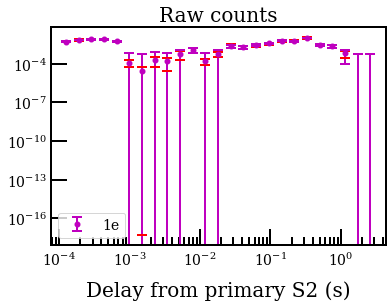

No handles with labels found to put in legend.


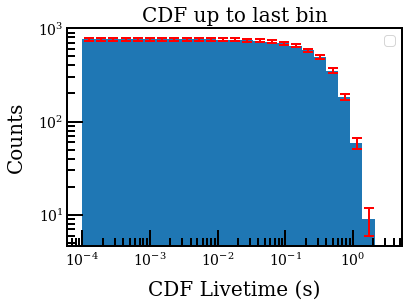

No handles with labels found to put in legend.


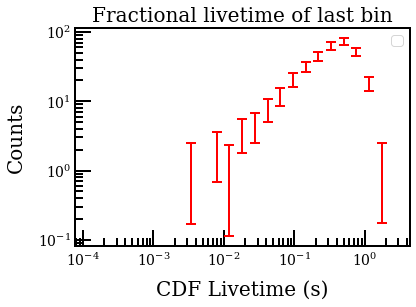

Optimization terminated successfully.
         Current function value: -289.895273
         Iterations: 115
         Function evaluations: 214
Optimization terminated successfully.
         Current function value: -289.895273
         Iterations: 49
         Function evaluations: 93


/tmp/ipykernel_89965/2931770225.py:166: RuntimeWarning: invalid value encountered in true_divide
  rate = (count/livetime)*(purity/efficiency)
/tmp/ipykernel_89965/2931770225.py:167: RuntimeWarning: invalid value encountered in true_divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_89965/2931770225.py:169: RuntimeWarning: invalid value encountered in true_divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])
/tmp/ipykernel_89965/2931770225.py:172: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea = (count_noarea/livetime)*(purity/efficiency)
/tmp/ipykernel_89965/2931770225.py:173: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
/tmp/ipykernel_89965/2931770225.py:174: RuntimeWarning: invalid value encountered in true_divide
  weigh

In [84]:
rate_g, rate_err_g, bin_centers, centers_fit, results_g, integral, frac, frac_err = get_frac(data_se_gas, data_prim_gas, 'gas', True,se_range='se', position_range='all')


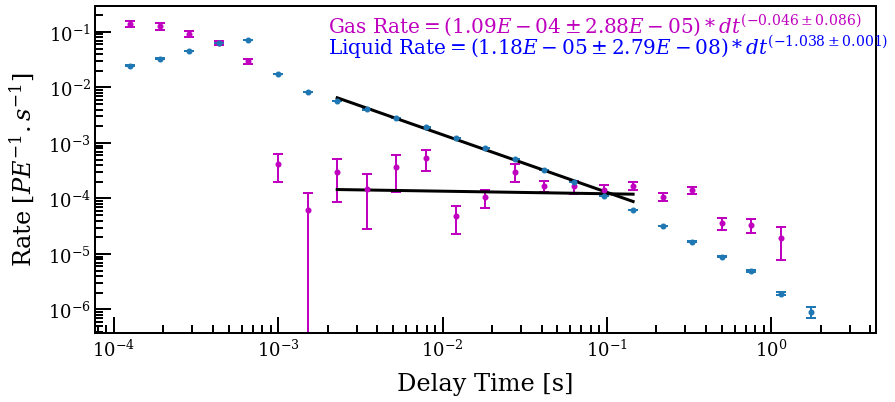

In [86]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_g, yerr=rate_err_g,color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_g[0], results_g[2], results_g[1], results_g[3]))
curvey1 = power(centers_fit,results_g[0],results_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 1e-1), fontsize=20, color='m')

plt.errorbar(bin_centers,rate_l, yerr=rate_err_l, fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l[0], results_l[2], results_l[1], results_l[3]))
curvey1 = power(centers_fit,results_l[0],results_l[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 4e-2), fontsize=20, color='b')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ PE^{-1}. s^{-1}$]')
# plt.ylim(1e-6,1e1)
plt.xticks()
plt.yticks()
plt.show()

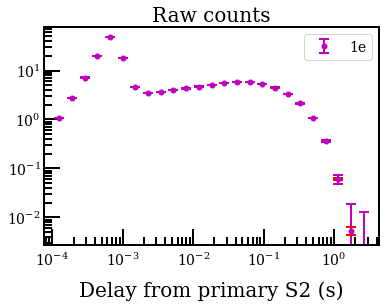

No handles with labels found to put in legend.


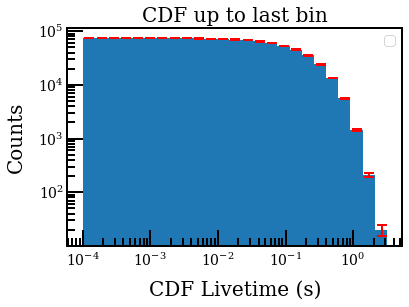

No handles with labels found to put in legend.


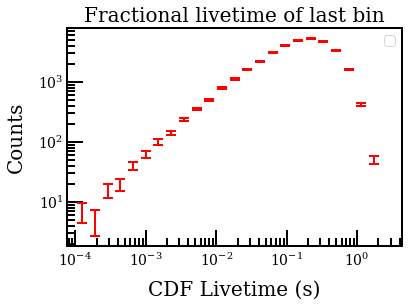

/tmp/ipykernel_89965/2931770225.py:167: RuntimeWarning: invalid value encountered in true_divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_89965/2931770225.py:169: RuntimeWarning: invalid value encountered in true_divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])
/tmp/ipykernel_89965/2931770225.py:173: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
/tmp/ipykernel_89965/2931770225.py:174: RuntimeWarning: invalid value encountered in true_divide
  weight_noarea_factor = np.nan_to_num(f_counts_corrected_noarea[0]/f_counts[0])


Optimization terminated successfully.
         Current function value: -2747371.024913
         Iterations: 147
         Function evaluations: 269
Optimization terminated successfully.
         Current function value: -2747515.346227
         Iterations: 42
         Function evaluations: 80


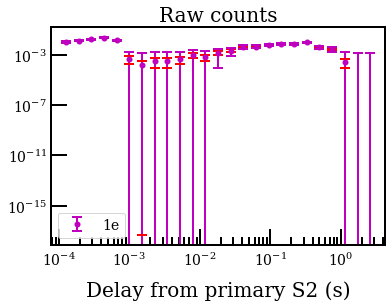

No handles with labels found to put in legend.


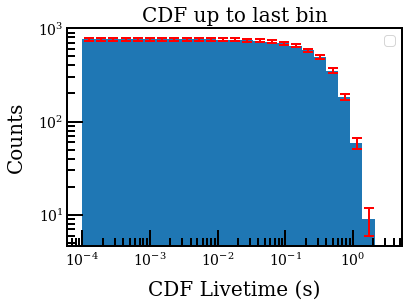

No handles with labels found to put in legend.


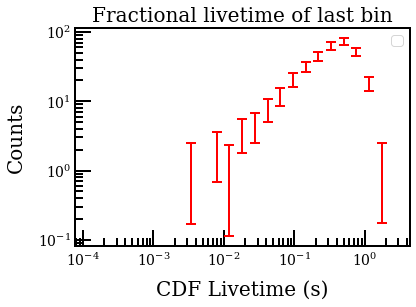

Optimization terminated successfully.
         Current function value: -274.669343
         Iterations: 129
         Function evaluations: 233
Optimization terminated successfully.
         Current function value: -264.755097
         Iterations: 50
         Function evaluations: 93


/tmp/ipykernel_89965/2931770225.py:166: RuntimeWarning: invalid value encountered in true_divide
  rate = (count/livetime)*(purity/efficiency)
/tmp/ipykernel_89965/2931770225.py:167: RuntimeWarning: invalid value encountered in true_divide
  rate_err = np.sqrt(((f_counts_corrected_errorbar/bin_width)/count)**2 + (window_err/livetime)**2)*rate
/tmp/ipykernel_89965/2931770225.py:169: RuntimeWarning: invalid value encountered in true_divide
  weight_factor = np.nan_to_num(f_counts_corrected[0]/f_counts[0])
/tmp/ipykernel_89965/2931770225.py:172: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea = (count_noarea/livetime)*(purity/efficiency)
/tmp/ipykernel_89965/2931770225.py:173: RuntimeWarning: invalid value encountered in true_divide
  rate_noarea_err = np.sqrt(((f_counts_corrected_noarea_errorbar/bin_width)/count_noarea)**2 + (window_err/livetime)**2)*rate_noarea
/tmp/ipykernel_89965/2931770225.py:174: RuntimeWarning: invalid value encountered in true_divide
  weigh

In [95]:
rate_se_uc_l, rate_err_se_uc_l, bin_centers, centers_fit, results_se_uc_l, integral, frac, frac_err = get_frac(data_se_liquid, data_prim_liquid, 'liquid', False,se_range='se', position_range='outer')
rate_se_uc_g, rate_err_se_uc_g, bin_centers, centers_fit, results_se_uc_g, integral, frac, frac_err = get_frac(data_se_gas, data_prim_gas, 'gas', False,se_range='se', position_range='outer')


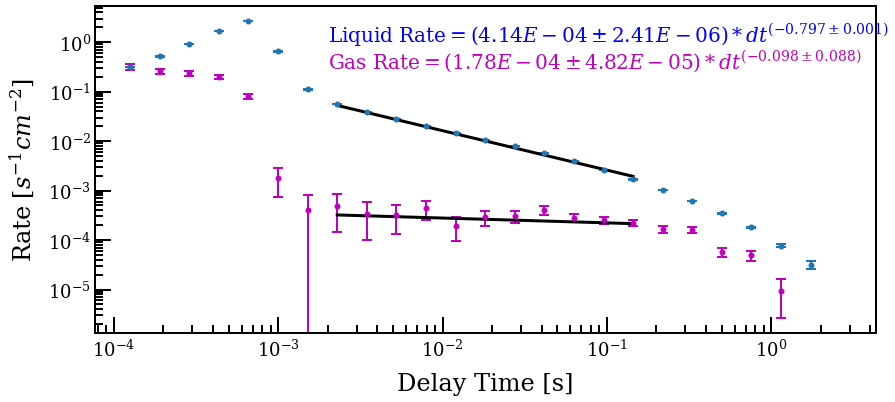

In [100]:
fig = plt.figure(figsize=(14, 6))

plt.errorbar(bin_centers,rate_se_uc_g, yerr=rate_err_se_uc_g,color='m', ecolor ='m' ,fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Gas Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_se_uc_g[0], results_se_uc_g[2], results_se_uc_g[1], results_se_uc_g[3]))
curvey1 = power(centers_fit,results_se_uc_g[0],results_se_uc_g[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 3e-1), fontsize=20, color='m')

plt.errorbar(bin_centers,rate_se_uc_l, yerr=rate_err_se_uc_l,fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_se_uc_l[0], results_se_uc_l[2], results_se_uc_l[1], results_se_uc_l[3]))
curvey1 = power(centers_fit,results_se_uc_l[0],results_se_uc_l[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 1e0), fontsize=20, color='b')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$s^{-1} cm^{-2}$]')
# plt.ylim(1e-6,1e1)
plt.xticks()
plt.yticks()
plt.show()

# Ignore - Rough analysis 

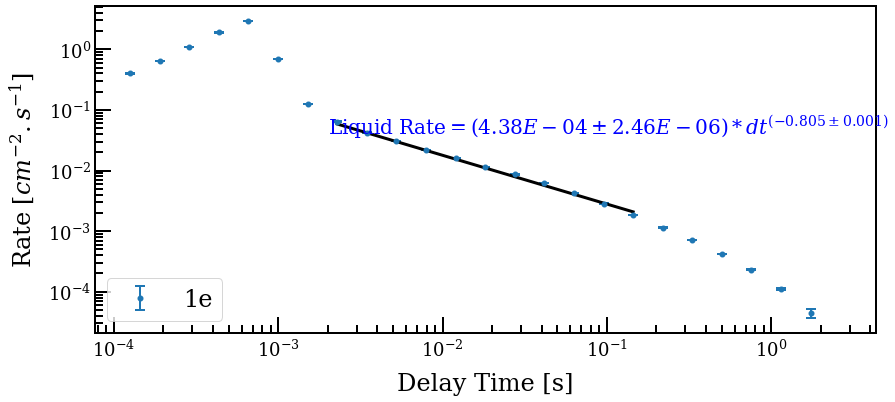

In [413]:
fig = plt.figure(figsize=(14, 6))


plt.errorbar(bin_centers,rate_l, yerr=rate_err_l, fmt='.' ,drawstyle = 'steps-mid', label='1e')
l1 = ('Liquid Rate$ = (%.2E \pm %.2E)* dt^{(%.3f \pm %.3f)}$' % (results_l[0], results_l[2], results_l[1], results_l[3]))
curvey1 = power(centers_fit,results_l[0],results_l[1])
plt.plot(centers_fit, curvey1, 'k-', linewidth=3)
plt.annotate(l1, xy=(2e-3, 4e-2), fontsize=20, color='b')

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Delay Time [s]')
plt.ylabel('Rate [$ cm^{-2}. s^{-1}$]')
# plt.ylim(1e-6,1e1)
plt.legend(loc=3)
plt.xticks()
plt.yticks()
plt.show()

In [92]:
f = plt.figure(figsize=(12,8))

m2 = Histdd(
            data_se['dt_primary'].values/1e9,
            data_se['area_primary'].values,bins=[np.logspace(-4,0,150),np.logspace(3,5,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Primary Area [PE]')
plt.xlabel('dt')
plt.show()

NameError: name 'data_se' is not defined

<Figure size 864x576 with 0 Axes>

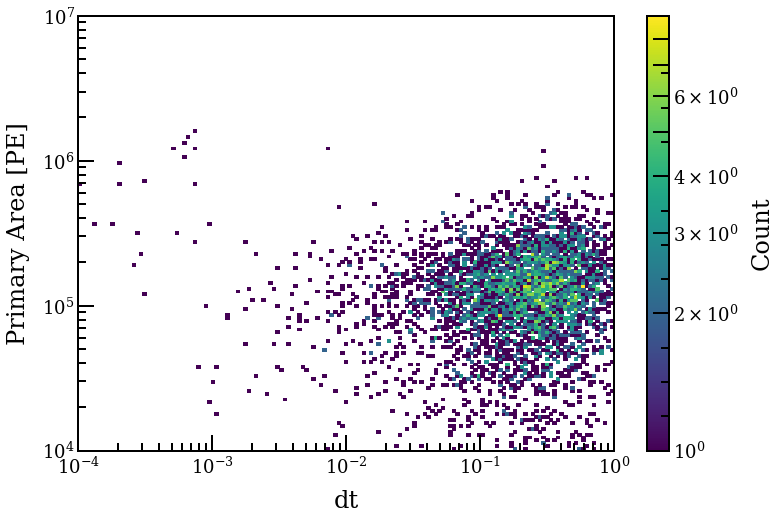

In [363]:
f = plt.figure(figsize=(12,8))

m2 = Histdd(
            data_prim['dt_primary'].values/1e9,
            data_prim['area_primary'].values,bins=[np.logspace(-4,0,150),np.logspace(4,7,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')

plt.xscale('log')
plt.yscale('log')
plt.ylabel('Primary Area [PE]')
plt.xlabel('dt')
plt.show()